In [1]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from src.nas.mlp_chromosome import RawChromosome


low, high = RawChromosome.get_bounds()
low, high

(array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 3, 8, 7, 8, 7, 8, 7, 2, 3, 3, 1, 1, 6, 3]))

In [9]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas import MlpNasParams
from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset


DatasetClass = VertebralDataset
params = MlpNasParams(
    epochs=10,
    patience=5,
    amount_of_evaluations=1,
    population_size=50,
    population_offspring_count=20,
    algorithm_generations=1,
    population_store_file=DatasetClass.__name__ + "_population.csv",
)
problem = MlpNasProblem(params, DatasetClass)

problem.get_min_complexity(), problem.get_max_complexity()

(162.0, np.float64(2160.0))

In [10]:
plow = problem.get_nn_params(RawChromosome(low).parse())
phigh = problem.get_nn_params(RawChromosome(high).parse())

problem.compute_nn_complexity(plow), problem.compute_nn_complexity(phigh)

(162.0, np.float64(2160.0))

In [11]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file is empty. Using random sampling


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      5 |             - |             -
Solutions: [[5 0 6 7 5 7 1 4 0 3 2 0 1 4 3]
 [2 0 7 4 8 3 8 2 0 1 3 0 1 6 0]
 [6 1 1 4 2 5 5 4 0 1 2 0 0 6 3]
 [3 0 2 1 7 4 5 6 2 0 3 0 0 2 0]
 [4 0 7 4 1 7 7 3 0 0 3 0 0 5 3]]
Objectives: [[-0.80645161  0.00275554  0.07142857]
 [-0.38709677  0.          0.        ]
 [-0.5         0.          0.28571429]
 [-0.46774194  0.08108108  0.        ]
 [-0.74193548  0.10718336  0.03571429]]


In [12]:
from dataclasses import asdict

from pprint import pprint
import pandas as pd
from pymoo.core.result import Result


def res_to_df(res: Result) -> pd.DataFrame:
    data = []
    for i in range(len(res.X)):
        x = res.X[i]
        f = res.F[i]
        accuracy = problem.denormalize(-f[0], 0, 100)
        complexity = problem.denormalize(
            f[1], problem.get_min_complexity(), problem.get_max_complexity()
        )

        ch = RawChromosome(x).parse()
        params = problem.get_nn_params(ch)

        data.append(
            {
                "Accuracy": accuracy,
                "Complexity": complexity,
                **asdict(params),
                "Chromosome": x,
            }
        )

    return pd.DataFrame(data)


df = res_to_df(res)
df

,Accuracy,Complexity,layers,activation,quantization_mode,dropout_rate,epochs,learning_rate,weight_decay,Chromosome
0,80.645161,167.505570,"[{'height': 6, 'bitwidth': 6}, {'height': 3, '...","{'activation': ActivationModule.TERNARIZE, 'bi...",QMode.DET,0.0,10,0.0020,0.001,"[5, 0, 6, 7, 5, 7, 1, 4, 0, 3, 2, 0, 1, 4, 3]"
1,38.709677,162.000000,"[{'height': 6, 'bitwidth': 3}, {'height': 3, '...",{'activation': ActivationModule.BINARIZE_RESTE...,QMode.DET,0.0,10,0.0100,0.010,"[2, 0, 7, 4, 8, 3, 8, 2, 0, 1, 3, 0, 1, 6, 0]"
2,50.000000,162.000000,"[{'height': 6, 'bitwidth': 7}, {'height': 1, '...",{'activation': ActivationModule.BINARIZE_RESTE...,QMode.DET,0.0,10,0.0100,0.001,"[6, 1, 1, 4, 2, 5, 5, 4, 0, 1, 2, 0, 0, 6, 3]"
3,46.774194,324.000000,"[{'height': 6, 'bitwidth': 4}, {'height': 3, '...","{'activation': ActivationModule.RELU, 'binary_...",QMode.DET,0.2,10,0.0005,0.010,"[3, 0, 2, 1, 7, 4, 5, 6, 2, 0, 3, 0, 0, 2, 0]"
4,74.193548,376.152351,"[{'height': 6, 'bitwidth': 5}, {'height': 3, '...","{'activation': ActivationModule.RELU, 'binary_...",QMode.DET,0.0,10,0.0050,0.001,"[4, 0, 7, 4, 1, 7, 7, 3, 0, 0, 3, 0, 0, 5, 3]"


In [13]:
ch = RawChromosome(df.loc[0]["Chromosome"]).parse()
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(layers=[FCLayerParams(height=6, bitwidth=6),
                  FCLayerParams(height=3, bitwidth=32)],
          activation=ActivationParams(activation=<ActivationModule.TERNARIZE: 'ternary'>,
                                      binary_quantization_mode=<QMode.DET: 'det'>,
                                      reste_o=np.int64(2),
                                      reste_threshold=1.5),
          quantization_mode=<QMode.DET: 'det'>,
          dropout_rate=0.0,
          epochs=10,
          learning_rate=0.002,
          weight_decay=0.001)


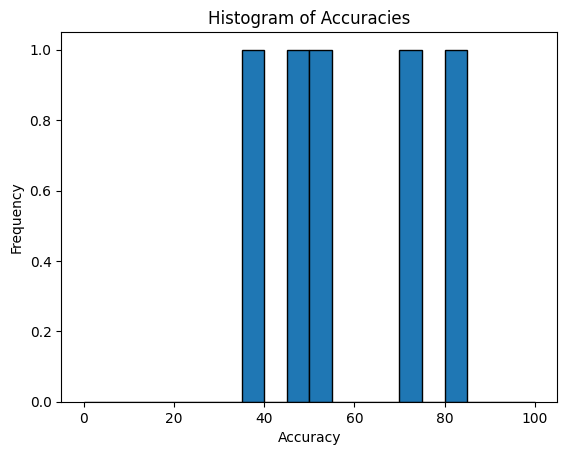

In [14]:
from matplotlib import pyplot as plt

from src.models.mlp import MLPEvaluator


def hist_accuracies(accuracies: list[float], bins=20) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.hist(accuracies, bins=bins, range=(0, 100), edgecolor="black")
    ax.set_title("Histogram of Accuracies")
    ax.set_xlabel("Accuracy")
    ax.set_ylabel("Frequency")
    return fig


fig = hist_accuracies(df["Accuracy"])

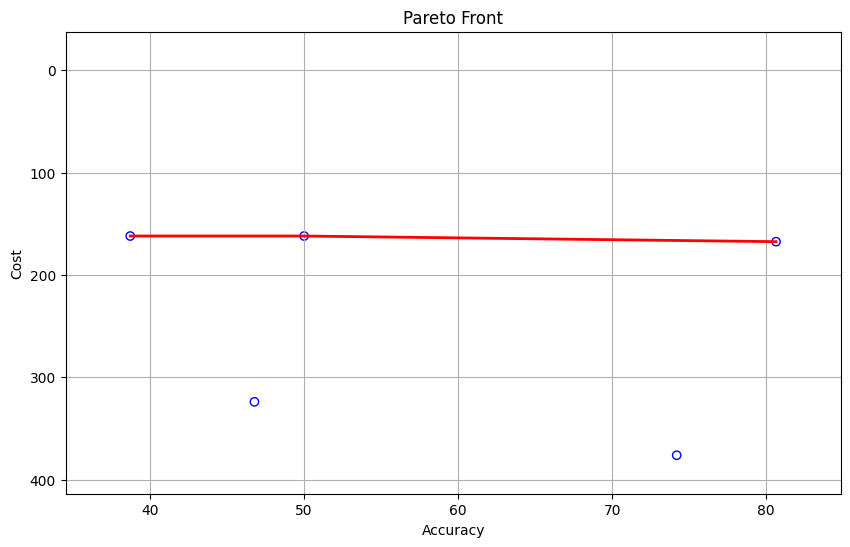

In [15]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])